In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import pertpy as pt
import scanpy as sc
import pandas as pd
import seaborn as sb

plt.rcParams["figure.figsize"] = (7, 7)
import numpy as np

sc.settings.verbosity = 3


import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm, colors

#Define a nice colour map for gene expression
colors2 = plt.cm.plasma(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

%load_ext rpy2.ipython

## Define color palette
pal = sb.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

import os,sys

figdir = './sysVI_mm_OL_figures/'
if not os.path.exists(figdir):
    os.mkdir(figdir)
sc.settings.figdir = figdir

In [2]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)
library(ggrastr)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



In [3]:
%%R -i design_palette_df -i figdir
design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

In [4]:
from adjustText import adjust_text
import matplotlib.patheffects as pe

def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [5]:
def plot_w_ggplot(r_fct_str, args, figdir='.', pl_name='plot', pl_width=8, pl_height=8):

    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP

    r_pkg = STAP(r_fct_str, "r_pkg")
    #this was needed for the code to run on jhub
    #if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    pl = r_pkg.plot_func(args)
    
    ggsave_str = '''
    save_plot <- function(pl, figdir, pl_name, pl_width, pl_height){
        pl + 
        ggsave(file.path(figdir, paste0(pl_name, ".png")), width=pl_width, height=pl_height)  +
        ggsave(file.path(figdir, paste0(pl_name, ".pdf")), width=pl_width, height=pl_height)
    }
    
    '''
    r_save = STAP(ggsave_str, "r_save")
    r_save.save_plot(pl, figdir, pl_name=pl_name, pl_width=pl_width, pl_height=pl_height)

# Read in all files for beeswarm MILO plots

In [6]:
LD = pd.read_csv('./nh_df_LPC_demyel_NEW_KEEP_ALL.csv', index_col=1)  # index_col=0 to set the first column as the index
LD.shape

(3865, 12)

In [7]:
LL = pd.read_csv('./nh_df_LPC_remyel_NEW_KEEP_ALL.csv', index_col=1)  # index_col=0 to set the first column as the index
LL.shape

(3865, 12)

In [8]:
CD = pd.read_csv('./nh_df_Cupr_demyel_NEW_KEEP_ALL.csv', index_col=1)  # index_col=0 to set the first column as the index
CD.shape

(3865, 12)

In [9]:
CR = pd.read_csv('./nh_df_Cupr_remyel_NEW_KEEP_ALL.csv', index_col=1)  # index_col=0 to set the first column as the index
CR.shape

(3865, 12)

In [10]:
CR.head()

,Unnamed: 0,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR,Sig,Nhood_size,nhood_annotation,nhood_annotation_frac
index_cell,,,,,,,,,,,,
CTTGATTTCGTCCTTG-1_adams,0,4.803607,0.000000,8.765427,0.000000,1.000000,1.000000,1.000000,False,100.0,NFOLs,1.000000
CCACACTCACCTCAGG-1_adams,1,3.926955,-3.665942,8.718165,2.395096,0.123486,0.275517,0.257263,False,108.0,MFOLs,0.972222
GTTTGGATCAAGAATG-1_adams,2,3.594900,-3.007286,8.731116,1.730901,0.189849,0.352434,0.333075,False,113.0,MFOLs,1.000000
TCACGCTCACTACTTT-1_adams,3,3.296920,-2.621104,9.203356,1.280756,0.259154,0.426226,0.405925,False,147.0,NFOLs,1.000000
TGAGGAGCAGGACTTT-1_adams,4,2.804393,-0.212899,9.087255,0.020525,0.886231,0.954649,0.940568,False,158.0,MFOLs,1.000000


In [11]:
# Compare indices
ld_index = LD.index
ll_index = LL.index
cd_index = CD.index
cr_index = CR.index

# Check if all indices are the same
if ld_index.equals(ll_index) and ld_index.equals(cd_index) and ld_index.equals(cr_index):
    print("All DataFrames have the same index.")
else:
    print("The DataFrames do not have the same index.")

All DataFrames have the same index.


In [12]:
# Drop rows where the 'nhood_annotation' column has the value 'Mixed'
LD = LD[LD['nhood_annotation'] != 'Mixed']

# Check the shape after dropping the rows
LD.shape

(3280, 12)

In [13]:
# Drop rows where the 'nhood_annotation' column has the value 'Mixed'
LL = LL[LL['nhood_annotation'] != 'Mixed']

# Check the shape after dropping the rows
LL.shape

(3280, 12)

In [14]:
# Drop rows where the 'nhood_annotation' column has the value 'Mixed'
CD = CD[CD['nhood_annotation'] != 'Mixed']

# Check the shape after dropping the rows
CD.shape

(3280, 12)

In [15]:
# Drop rows where the 'nhood_annotation' column has the value 'Mixed'
CR = CR[CR['nhood_annotation'] != 'Mixed']

# Check the shape after dropping the rows
CR.shape

(3280, 12)

# Individual plots

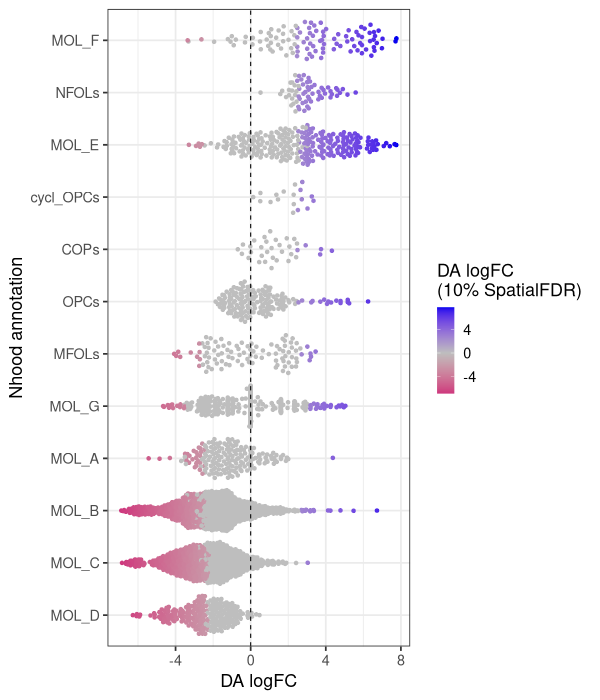

In [16]:
%%R -h 700 -w 600 -i LD

##ORIGINAL CODE

LD %>%
  # filter(nhood_annotation_frac > 0.5) %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(mean_lfc) %>%
  mutate(nhood_annotation = factor(nhood_annotation, levels = unique(nhood_annotation))) %>%
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 1.5) +
  coord_flip() +
  scale_color_gradient2(high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)') +
  theme_bw(base_size = 18) +
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') + 
  ylab('DA logFC')

# CORRECTED PLOTS!

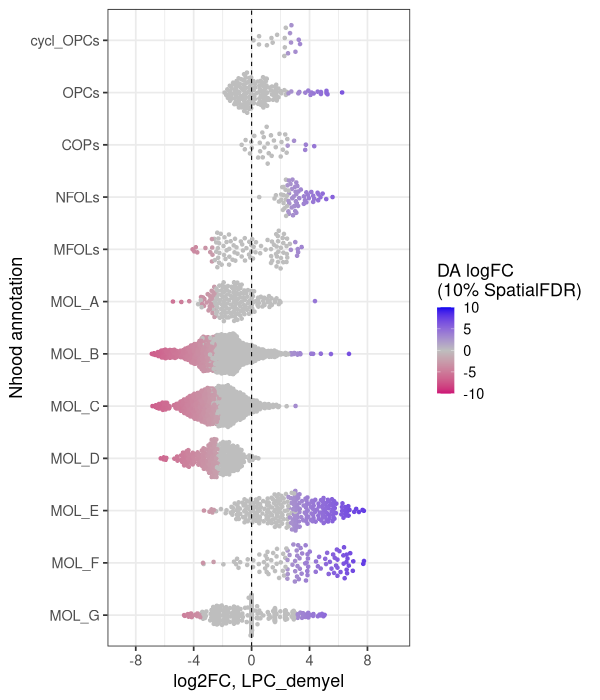

In [23]:
%%R -h 700 -w 600 -i LD

# Define the desired order of nhood_annotation
desired_order <- rev(c(
    "cycl_OPCs", "OPCs", "COPs", "NFOLs", "MFOLs","MOL_A", "MOL_B", "MOL_C", "MOL_D", "MOL_E", "MOL_F", "MOL_G"
))

LD %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(factor(nhood_annotation, levels = desired_order)) %>%  # Arrange by desired order
  mutate(nhood_annotation = factor(nhood_annotation, levels = desired_order)) %>%  # Reorder factor levels
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 1.5) +
  coord_flip() +
  scale_color_gradient2(
    limits = c(-10, 10),  # Set color scale limits
    breaks = c(-10, -5, 0, 5, 10),  # Specify breaks on the color scale
    labels = c(-10, -5, 0, 5, 10),  # Specify labels on the color scale
    high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)'
  ) +
  theme_bw(base_size = 18) +
  scale_y_continuous(limits = c(-9, 10), breaks = c(-4, -8, 0, 4, 8)) +  # Adjust y-axis limits and breaks
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') + 
  ylab('log2FC, LPC_demyel')
  ggsave(paste0(figdir, 'beeswarm_fine_anno_LPC_early_ALL_scaled.png'), width = 10, height = 12)

print(last_plot())

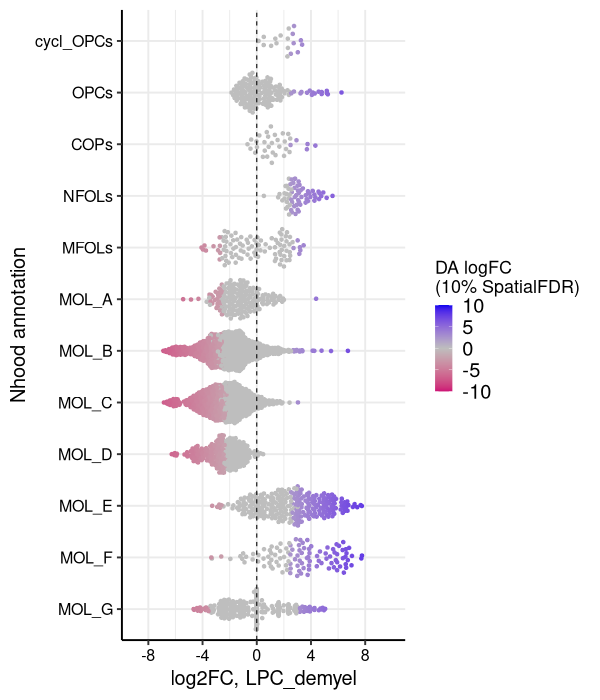

In [24]:
%%R -h 700 -w 600 -i LD

# Define the desired order of nhood_annotation
desired_order <- rev(c(
    "cycl_OPCs", "OPCs", "COPs", "NFOLs", "MFOLs","MOL_A", "MOL_B", "MOL_C", "MOL_D", "MOL_E", "MOL_F", "MOL_G"
))


LD %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(factor(nhood_annotation, levels = desired_order)) %>%  # Arrange by desired order
  mutate(nhood_annotation = factor(nhood_annotation, levels = desired_order)) %>%  # Reorder factor levels
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 1.5) +
  coord_flip() +
  scale_color_gradient2(
    limits = c(-10, 10),  # Set color scale limits
    breaks = c(-10, -5, 0, 5, 10),  # Specify breaks on the color scale
    labels = c(-10, -5, 0, 5, 10),  # Specify labels on the color scale
      
    high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)'
  ) +
  theme_bw(base_size = 20) +  # Set the global base font size
  theme(
    text = element_text(size = 20, color = "black", family = "sans"),  # Use 'sans' font for consistency
    axis.title = element_text(size = 20, color = "black", family = "sans"),  # Axis titles
    axis.text = element_text(size = 16, color = "black", family = "sans"),   # Axis labels
    legend.text = element_text(size = 20, color = "black", family = "sans"), # Legend text
    legend.title = element_text(size = 18, color = "black", family = "sans"), # Legend title
    panel.border = element_blank(),  # Remove the entire panel border
    axis.line = element_line(color = "black")  # Keep only the axis lines
  ) +
  scale_y_continuous(limits = c(-9, 10), breaks = c(-4, -8, 0, 4, 8)) +  # Adjust y-axis limits and breaks
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') + 
  ylab('log2FC, LPC_demyel')

ggsave(paste0(figdir, 'beeswarm_fine_anno_LPC_early_ALL_scaled.png'), width = 10, height = 12)

print(last_plot())

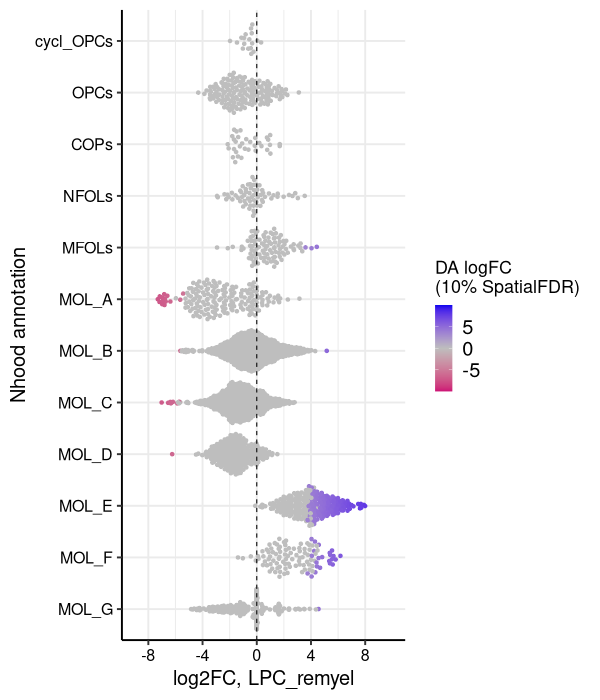

In [20]:
%%R -h 700 -w 600 -i LL

# Define the desired order of nhood_annotation
desired_order <- rev(c(
    "cycl_OPCs", "OPCs", "COPs", "NFOLs", "MFOLs","MOL_A", "MOL_B", "MOL_C", "MOL_D", "MOL_E", "MOL_F", "MOL_G"
))


LL %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(factor(nhood_annotation, levels = desired_order)) %>%  # Arrange by desired order
  mutate(nhood_annotation = factor(nhood_annotation, levels = desired_order)) %>%  # Reorder factor levels
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 1.5) +
  coord_flip() +
  scale_color_gradient2(
    limits = c(-10, 10),  # Set color scale limits
    breaks = c(-5, 0, 5),  # Specify breaks on the color scale
    labels = c(-5, 0, 5),  # Specify labels on the color scale
    high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)'
  ) +
  theme_bw(base_size = 20) +  # Set the global base font size
  theme(
    text = element_text(size = 20, color = "black", family = "sans"),  # Use 'sans' font for consistency
    axis.title = element_text(size = 20, color = "black", family = "sans"),  # Axis titles
    axis.text = element_text(size = 16, color = "black", family = "sans"),   # Axis labels
    legend.text = element_text(size = 20, color = "black", family = "sans"), # Legend text
    legend.title = element_text(size = 18, color = "black", family = "sans"), # Legend title
    panel.border = element_blank(),  # Remove the entire panel border
    axis.line = element_line(color = "black")  # Keep only the axis lines
  ) +
  scale_y_continuous(limits = c(-9, 10), breaks = c(-4, -8, 0, 4, 8)) +  # Adjust y-axis limits and breaks
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') + 
  ylab('log2FC, LPC_remyel')

ggsave(paste0(figdir, 'beeswarm_fine_anno_LPC_remyel_ALL_scaled.png'), width = 10, height = 12)

print(last_plot())

In [25]:
%%R
# Filter and display rows where logFC is NA
CD_na <- CD %>% 
  filter(is.na(logFC))

# Display the filtered dataframe
print(CD_na)

 [1] Unnamed: 0            kth_distance          logFC                
 [4] logCPM                F                     PValue               
 [7] FDR                   SpatialFDR            Sig                  
[10] Nhood_size            nhood_annotation      nhood_annotation_frac
<0 rows> (or 0-length row.names)


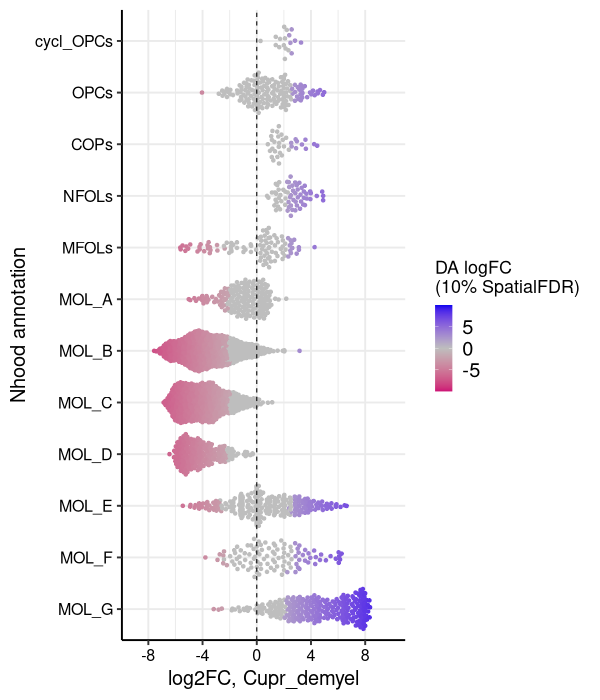

In [21]:
%%R -h 700 -w 600 -i CD

# Define the desired order of nhood_annotation
# Define the desired order of nhood_annotation
desired_order <- rev(c(
    "cycl_OPCs", "OPCs", "COPs", "NFOLs", "MFOLs","MOL_A", "MOL_B", "MOL_C", "MOL_D", "MOL_E", "MOL_F", "MOL_G"
))


CD %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(factor(nhood_annotation, levels = desired_order)) %>%  # Arrange by desired order
  mutate(nhood_annotation = factor(nhood_annotation, levels = desired_order)) %>%  # Reorder factor levels
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 1.5) +
  coord_flip() +
  scale_color_gradient2(
    limits = c(-10, 10),  # Set color scale limits
    breaks = c(-5, 0, 5),  # Specify breaks on the color scale
    labels = c(-5, 0, 5),  # Specify labels on the color scale
    high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)'
  ) +
  theme_bw(base_size = 20) +  # Set the global base font size
  theme(
    text = element_text(size = 20, color = "black", family = "sans"),  # Use 'sans' font for consistency
    axis.title = element_text(size = 20, color = "black", family = "sans"),  # Axis titles
    axis.text = element_text(size = 16, color = "black", family = "sans"),   # Axis labels
    legend.text = element_text(size = 20, color = "black", family = "sans"), # Legend text
    legend.title = element_text(size = 18, color = "black", family = "sans"), # Legend title
    panel.border = element_blank(),  # Remove the entire panel border
    axis.line = element_line(color = "black")  # Keep only the axis lines
  ) +
  scale_y_continuous(limits = c(-9, 10), breaks = c(-4, -8, 0, 4, 8)) +  # Adjust y-axis limits and breaks
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') + 
  ylab('log2FC, Cupr_demyel')

ggsave(paste0(figdir, 'beeswarm_fine_anno_Cupr_demyel_ALL_scaled.png'), width = 10, height = 12)

print(last_plot())

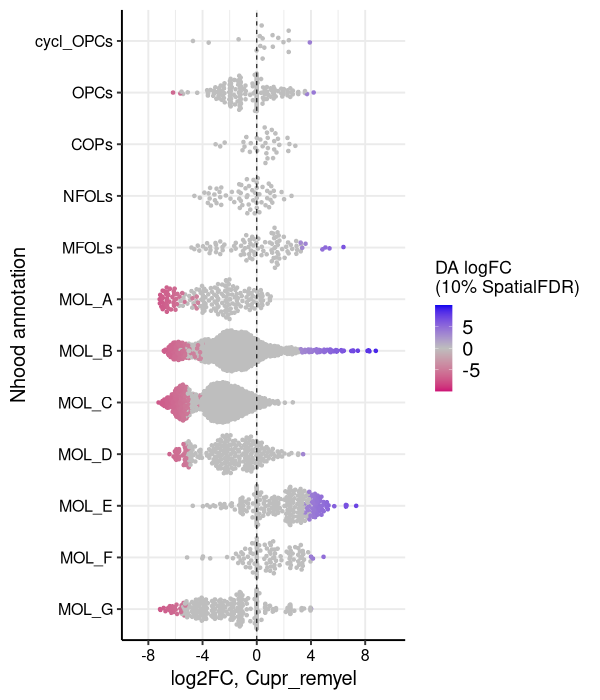

In [22]:
%%R -h 700 -w 600 -i CR

# Define the desired order of nhood_annotation
# Define the desired order of nhood_annotation
desired_order <- rev(c(
    "cycl_OPCs", "OPCs", "COPs", "NFOLs", "MFOLs","MOL_A", "MOL_B", "MOL_C", "MOL_D", "MOL_E", "MOL_F", "MOL_G"
))


CR %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(factor(nhood_annotation, levels = desired_order)) %>%  # Arrange by desired order
  mutate(nhood_annotation = factor(nhood_annotation, levels = desired_order)) %>%  # Reorder factor levels
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 1.5) +
  coord_flip() +
  scale_color_gradient2(
    limits = c(-10, 10),  # Set color scale limits
    breaks = c(-5, 0, 5),  # Specify breaks on the color scale
    labels = c(-5, 0, 5),  # Specify labels on the color scale
    high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)'
  ) +
  theme_bw(base_size = 20) +  # Set the global base font size
  theme(
    text = element_text(size = 20, color = "black", family = "sans"),  # Use 'sans' font for consistency
    axis.title = element_text(size = 20, color = "black", family = "sans"),  # Axis titles
    axis.text = element_text(size = 16, color = "black", family = "sans"),   # Axis labels
    legend.text = element_text(size = 20, color = "black", family = "sans"), # Legend text
    legend.title = element_text(size = 18, color = "black", family = "sans"), # Legend title
    panel.border = element_blank(),  # Remove the entire panel border
    axis.line = element_line(color = "black")  # Keep only the axis lines
  ) +
  scale_y_continuous(limits = c(-9, 10), breaks = c(-4, -8, 0, 4, 8)) +  # Adjust y-axis limits and breaks
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') + 
  ylab('log2FC, Cupr_remyel')

ggsave(paste0(figdir, 'beeswarm_fine_anno_Cupr_remyel_ALL_scaled.png'), width = 10, height = 12)

print(last_plot())

# Formatting?

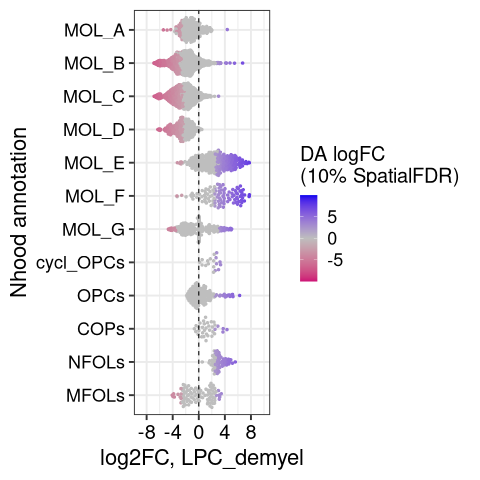

In [28]:
%%R

LD %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(factor(nhood_annotation, levels = desired_order)) %>%
  mutate(nhood_annotation = factor(nhood_annotation, levels = desired_order)) %>%
  ggplot(aes(nhood_annotation, logFC, color = signif)) +
  ggbeeswarm::geom_quasirandom(size = 1) +
  coord_flip() +
  scale_color_gradient2(
    limits = c(-10, 10),
    breaks = c(-5, 0, 5),
    labels = c(-5, 0, 5),
    high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)'
  ) +
  theme_bw(base_size = 20) +
  scale_y_continuous(limits = c(-9, 10), breaks = c(-8, -4, 0, 4, 8)) +
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') +
  ylab('log2FC, LPC_demyel') +
  theme(
    axis.text.x = element_text(size = 20, color = "black"),  # Change x-axis text to black
    axis.text.y = element_text(size = 18, color = "black"),  # Change y-axis text to black
    axis.title.x = element_text(size = 22, color = "black"), # Change x-axis title to black
    axis.title.y = element_text(size = 22, color = "black"), # Change y-axis title to black
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 18)
  )


# Save the plot
ggsave(paste0(figdir, 'beeswarm_fine_anno_LPC_early_ALL_scaled_NEW.png'), width = 14, height = 14)

print(last_plot())

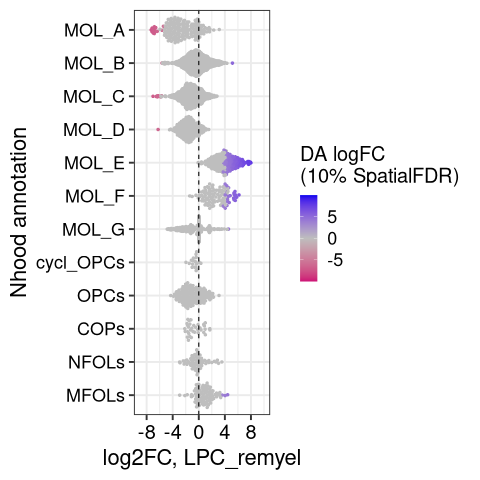

In [29]:
%%R

LL %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(factor(nhood_annotation, levels = desired_order)) %>%
  mutate(nhood_annotation = factor(nhood_annotation, levels = desired_order)) %>%
  ggplot(aes(nhood_annotation, logFC, color = signif)) +
  ggbeeswarm::geom_quasirandom(size = 1) +
  coord_flip() +
  scale_color_gradient2(
    limits = c(-10, 10),
    breaks = c(-5, 0, 5),
    labels = c(-5, 0, 5),
    high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)'
  ) +
  theme_bw(base_size = 20) +
  scale_y_continuous(limits = c(-9, 10), breaks = c(-8, -4, 0, 4, 8)) +
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') +
  ylab('log2FC, LPC_remyel') +
  theme(
    axis.text.x = element_text(size = 20, color = "black"),  # Change x-axis text to black
    axis.text.y = element_text(size = 18, color = "black"),  # Change y-axis text to black
    axis.title.x = element_text(size = 22, color = "black"), # Change x-axis title to black
    axis.title.y = element_text(size = 22, color = "black"), # Change y-axis title to black
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 18)
  )

ggsave(paste0(figdir, 'beeswarm_fine_anno_LPC_remyel_ALL_scaled_NEW.png'), width = 14, height = 14)

print(last_plot())

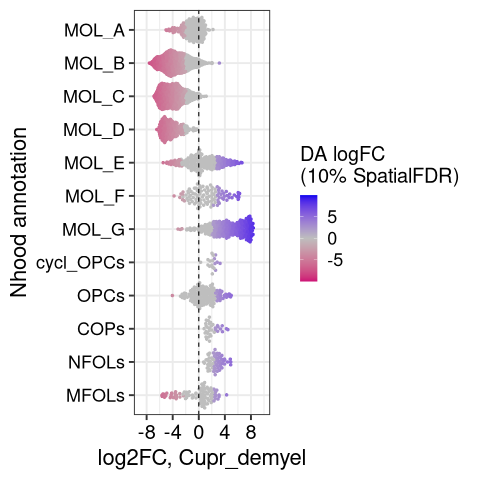

In [30]:
%%R

CD %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(factor(nhood_annotation, levels = desired_order)) %>%
  mutate(nhood_annotation = factor(nhood_annotation, levels = desired_order)) %>%
  ggplot(aes(nhood_annotation, logFC, color = signif)) +
  ggbeeswarm::geom_quasirandom(size = 1) +
  coord_flip() +
  scale_color_gradient2(
    limits = c(-10, 10),
    breaks = c(-5, 0, 5),
    labels = c(-5, 0, 5),
    high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)'
  ) +
  theme_bw(base_size = 20) +
  scale_y_continuous(limits = c(-9, 10), breaks = c(-8, -4, 0, 4, 8)) +
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') +
  ylab('log2FC, Cupr_demyel') +
  theme(
    axis.text.x = element_text(size = 20, color = "black"),  # Change x-axis text to black
    axis.text.y = element_text(size = 18, color = "black"),  # Change y-axis text to black
    axis.title.x = element_text(size = 22, color = "black"), # Change x-axis title to black
    axis.title.y = element_text(size = 22, color = "black"), # Change y-axis title to black
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 18)
  )

ggsave(paste0(figdir, 'beeswarm_fine_anno_Cupr_demyel_ALL_scaled_NEW.png'), width = 14, height = 14)

print(last_plot())

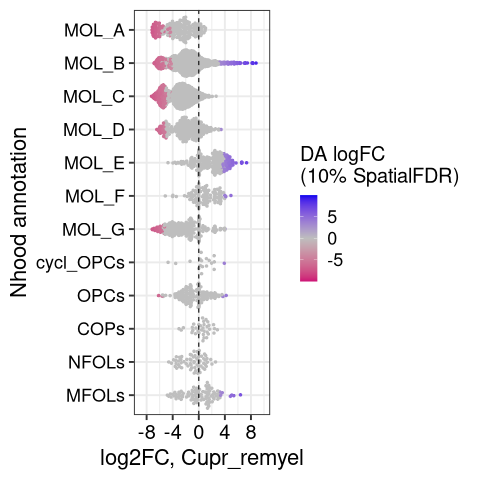

In [35]:
%%R

CR %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(factor(nhood_annotation, levels = desired_order)) %>%
  mutate(nhood_annotation = factor(nhood_annotation, levels = desired_order)) %>%
  ggplot(aes(nhood_annotation, logFC, color = signif)) +
  ggbeeswarm::geom_quasirandom(size = 1) +
  coord_flip() +
  scale_color_gradient2(
    limits = c(-10, 10),
    breaks = c(-5, 0, 5),
    labels = c(-5, 0, 5),
    high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)'
  ) +
  theme_bw(base_size = 20) +
  scale_y_continuous(limits = c(-9, 10), breaks = c(-8, -4, 0, 4, 8)) +
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') +
  ylab('log2FC, Cupr_remyel') +
  theme(
    axis.text.x = element_text(size = 20, color = "black"),  # Change x-axis text to black
    axis.text.y = element_text(size = 18, color = "black"),  # Change y-axis text to black
    axis.title.x = element_text(size = 22, color = "black"), # Change x-axis title to black
    axis.title.y = element_text(size = 22, color = "black"), # Change y-axis title to black
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 18)
  )

ggsave(paste0(figdir, 'beeswarm_fine_anno_Cupr_remyel_ALL_scaled_NEW.png'), width = 14, height = 14)

print(last_plot())

# Now add changes to additional data

In [ ]:
%%R -h 700 -w 600 -i LL

# Define the desired order of nhood_annotation
desired_order <- rev(c(
    "MOL_A", "MOL_B", "MOL_C", "MOL_D", "MOL_E", 
    "MOL_F", "MOL_G", "cycl_OPCs", "OPCs", "COPs", "NFOLs", "MFOLs"
))


LL %>%
  # filter(nhood_annotation_frac > 0.5) %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(factor(nhood_annotation, levels = desired_order)) %>%  # Arrange by desired order
  mutate(nhood_annotation = factor(nhood_annotation, levels = desired_order)) %>%  # Reorder factor levels
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 1.5) +
  coord_flip() +
  scale_color_gradient2(high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)') +
  theme_bw(base_size = 18) +
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') + 
  ylab('DA logFC')


In [ ]:
%%R -h 700 -w 600 -i CD

# Define the desired order of nhood_annotation
desired_order <- rev(c(
    "MOL4_DAO1", "MOL2_DAO1", "MOL1_DAO2", "cycling", "OPCs", 
    "COPs", "NFOLs", "MFOLs", "Mixed", "MOL1", "MOL2", "MOL3", "MOL4"
))


CD %>%
  # filter(nhood_annotation_frac > 0.5) %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(factor(nhood_annotation, levels = desired_order)) %>%  # Arrange by desired order
  mutate(nhood_annotation = factor(nhood_annotation, levels = desired_order)) %>%  # Reorder factor levels
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 1.5) +
  coord_flip() +
  scale_color_gradient2(high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)') +
  theme_bw(base_size = 18) +
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') + 
  ylab('DA logFC')

In [ ]:
%%R -h 700 -w 600 -i CR

# Define the desired order of nhood_annotation
desired_order <- rev(c(
    "MOL4_DAO1", "MOL2_DAO1", "MOL1_DAO2", "cycling", "OPCs", 
    "COPs", "NFOLs", "MFOLs", "Mixed", "MOL1", "MOL2", "MOL3", "MOL4"
))


CR %>%
  # filter(nhood_annotation_frac > 0.5) %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(factor(nhood_annotation, levels = desired_order)) %>%  # Arrange by desired order
  mutate(nhood_annotation = factor(nhood_annotation, levels = desired_order)) %>%  # Reorder factor levels
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 1.5) +
  coord_flip() +
  scale_color_gradient2(high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)') +
  theme_bw(base_size = 18) +
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') + 
  ylab('DA logFC')

## CORRECTED PLOTS!-- EDITED FOR SCALES

In addition: Warning message:
The `guide` argument in `scale_*()` cannot be `FALSE`. This was deprecated in
ggplot2 3.3.4.
ℹ Please use "none" instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


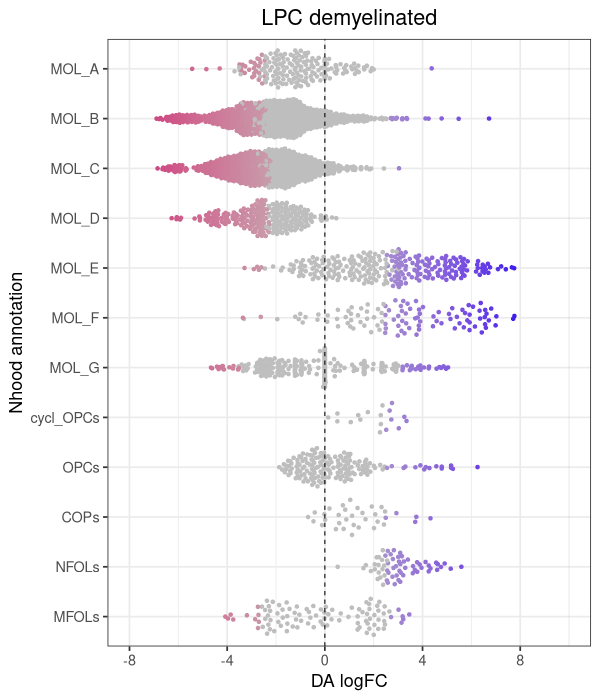

In [29]:
%%R -h 700 -w 600 -i LD

# Define the desired order of nhood_annotation
desired_order <- rev(c(
    "MOL_A", "MOL_B", "MOL_C", "MOL_D", "MOL_E", 
    "MOL_F", "MOL_G", "cycl_OPCs", "OPCs", "COPs", "NFOLs", "MFOLs"
))

LD %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(factor(nhood_annotation, levels = desired_order)) %>%  # Arrange by desired order
  mutate(nhood_annotation = factor(nhood_annotation, levels = desired_order)) %>%  # Reorder factor levels
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 1.5) +
  coord_flip() +
  scale_color_gradient2(
    limits = c(-7, 8.5),  # Set color scale limits
    breaks = c(-5, 0, 5),  # Specify breaks on the color scale
    labels = c(-5, 0, 5),  # Specify labels on the color scale
    high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)', guide=FALSE) +
  theme_bw(base_size = 18) +
  scale_y_continuous(limits = c(-8, 10), breaks = c(-4, -8, 0, 4, 8)) +  # Adjust y-axis limits and breaks
  geom_hline(yintercept = 0, linetype = 2) +
  geom_hline(yintercept = 10, linetype = 'solid', color = 'grey', alpha=0.3) +  # Add vertical line at x = 10
  xlab('Nhood annotation') + 
  ylab('DA logFC') +
  labs(title = "LPC demyelinated") +
  theme(plot.title = element_text(hjust = 0.5))
  ggsave(paste0(figdir, 'beeswarm_fine_anno_LPC_demyel_ALL_scaled_NEW.png'), width = 10, height = 12)

print(last_plot())

In [ ]:
%%R -h 700 -w 600 -i LL

# Define the desired order of nhood_annotation
desired_order <- rev(c(
    "MOL4_DAO1", "MOL2_DAO1", "MOL1_DAO2", "cycling", "OPCs", 
    "COPs", "NFOLs", "MFOLs", "Mixed", "MOL1", "MOL2", "MOL3", "MOL4"
))

LL %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(factor(nhood_annotation, levels = desired_order)) %>%  # Arrange by desired order
  mutate(nhood_annotation = factor(nhood_annotation, levels = desired_order)) %>%  # Reorder factor levels
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 1.5) +
  coord_flip() +
  scale_color_gradient2(
    limits = c(-7, 8.5),  # Set color scale limits
    breaks = c(-5, 0, 5),  # Specify breaks on the color scale
    labels = c(-5, 0, 5),  # Specify labels on the color scale
    high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)', guide=FALSE) +
  theme_bw(base_size = 18) +
  scale_y_continuous(limits = c(-8, 10), breaks = c(-4, -8, 0, 4, 8)) +  # Adjust y-axis limits and breaks
  geom_hline(yintercept = 0, linetype = 2) +
  geom_hline(yintercept = 10, linetype = 'solid', color = 'grey', alpha=0.3) +  # Add vertical line at x = 10
  xlab('Nhood annotation') + 
  ylab('DA logFC') +
  labs(title = "LPC remyelinated (late)") +
  theme(plot.title = element_text(hjust = 0.5)) +
  theme(axis.title.y = element_blank())  # Remove Y-axis label
  ggsave(paste0(figdir, 'beeswarm_fine_anno_LPC_late_ALL_scaled.png'), width = 10, height = 12)

print(last_plot())

In [ ]:
%%R -h 700 -w 600 -i CD

# Define the desired order of nhood_annotation
desired_order <- rev(c(
    "MOL4_DAO1", "MOL2_DAO1", "MOL1_DAO2", "cycling", "OPCs", 
    "COPs", "NFOLs", "MFOLs", "Mixed", "MOL1", "MOL2", "MOL3", "MOL4"
))

CD %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(factor(nhood_annotation, levels = desired_order)) %>%  # Arrange by desired order
  mutate(nhood_annotation = factor(nhood_annotation, levels = desired_order)) %>%  # Reorder factor levels
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 1.5) +
  coord_flip() +
  scale_color_gradient2(
    limits = c(-7, 8.5),  # Set color scale limits
    breaks = c(-5, 0, 5),  # Specify breaks on the color scale
    labels = c(-5, 0, 5),  # Specify labels on the color scale
    high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)', guide=FALSE) +
  theme_bw(base_size = 18) +
  scale_y_continuous(limits = c(-8, 10), breaks = c(-4, -8, 0, 4, 8)) +  # Adjust y-axis limits and breaks
  geom_hline(yintercept = 0, linetype = 2) +
  geom_hline(yintercept = 10, linetype = 'solid', color = 'grey', alpha=0.3) +  # Add vertical line at x = 10
  xlab('Nhood annotation') + 
  ylab('DA logFC') +
  labs(title = "Cupr demyelinated") +
  theme(plot.title = element_text(hjust = 0.5)) +
  theme(axis.title.y = element_blank())  # Remove Y-axis label
  ggsave(paste0(figdir, 'beeswarm_fine_anno_cupr_demyel_ALL_scaled.png'), width = 10, height = 12)

print(last_plot())

In [ ]:
%%R -h 700 -w 600 -i CR

# Define the desired order of nhood_annotation
desired_order <- rev(c(
    "MOL4_DAO1", "MOL2_DAO1", "MOL1_DAO2", "cycling", "OPCs", 
    "COPs", "NFOLs", "MFOLs", "Mixed", "MOL1", "MOL2", "MOL3", "MOL4"
))

CR %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(factor(nhood_annotation, levels = desired_order)) %>%  # Arrange by desired order
  mutate(nhood_annotation = factor(nhood_annotation, levels = desired_order)) %>%  # Reorder factor levels
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 1.5) +
  coord_flip() +
  scale_color_gradient2(
    limits = c(-7, 8.5),  # Set color scale limits
    breaks = c(-5, 0, 5),  # Specify breaks on the color scale
    labels = c(-5, 0, 5),  # Specify labels on the color scale
    high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)', guide=FALSE) +
  theme_bw(base_size = 18) +
  scale_y_continuous(limits = c(-8, 10), breaks = c(-4, -8, 0, 4, 8)) +  # Adjust y-axis limits and breaks
  geom_hline(yintercept = 0, linetype = 2) +
  geom_hline(yintercept = 10, linetype = 'solid', color = 'grey', alpha=0.3) +  # Add vertical line at x = 10
  xlab('Nhood annotation') + 
  ylab('DA logFC') +
  labs(title = "Cupr remyelinated") +
  theme(plot.title = element_text(hjust = 0.5)) +
  theme(axis.title.y = element_blank())  # Remove Y-axis label
  ggsave(paste0(figdir, 'beeswarm_fine_anno_cupr_remyel_ALL_scaled.png'), width = 10, height = 12)

print(last_plot())

In [ ]:
%%R -h 700 -w 600

# Define a basic plot with no data, just for the color scale
color_scale_plot <- ggplot() +
  scale_color_gradient2(
    limits = c(-7, 8.5),  # Set color scale limits
    breaks = c(-5, 0, 5),  # Specify breaks on the color scale
    labels = c(-5, 0, 5),  # Specify labels on the color scale
    high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)'
  ) +
  theme_minimal()

# Save the color scale plot
ggsave("./sysVI_mm_OL_figures/color_scale_plot.png", plot = color_scale_plot, width = 6, height = 4)